#Файзуллов Айрат

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


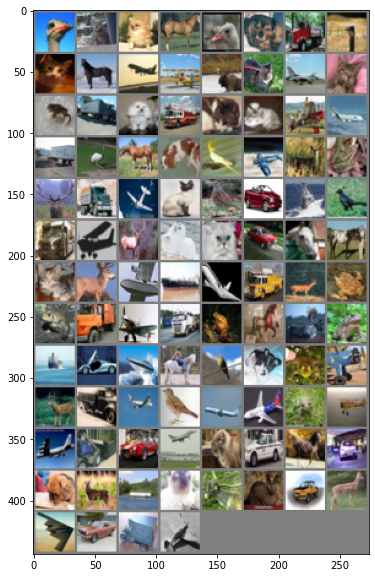

 bird   cat   dog horse  bird   dog truck  bird


In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)

        y = self.fc2(x)
        y = self.ReLU(y)
        y = self.fc3(y)

        x1 = self.ReLU(y + x)

        
        y1 = self.fc4(x1)
        y1 = self.ReLU(y1)
        y1 = self.fc5(y1)

        x2 = self.ReLU(x1 + y1)

        z = self.fc6(x2)
        return F.log_softmax(z, dim=1)

In [4]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [5]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
log_interval = 50
epochs = 7

In [7]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, epochs + 1):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.321483
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.739291
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.640297
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.636557
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.594428
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.657193
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.487859
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.675876
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.683219
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.591075

Test set: Average loss: 1.4711, Accuracy: 4788/10000 (48%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.428388
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.368579
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.597876
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.352616
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.395836
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.185490
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.450197
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.289582
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.299738
T

# Начало моего решения:

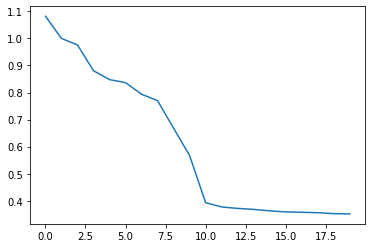

In [8]:
change = model.fc5.weight.detach().numpy()
U, S, Vh = np.linalg.svd(change)
S = S[:20]
plt.plot(S[::] / S[1])

Видим, что достигается плато, можно сделать вывод, что достаточно брать конечное кол-во сингулярных чисел для сжатия матрицы и таким образом точность предсказания сильно не ухудшится 

Реализуем разбиение весов по SVD, напишем новый класс Net_SVD 

In [91]:
import scipy.sparse.linalg as spsplin
class Net_SVD(nn.Module):
    def __init__(self, x: Net, r: int, lst: list):
        super(Net_SVD, self).__init__() 
        for i in range(1, 7):
          word = 'fc' + str(i)
          self._modules[word] = x._modules[word]
          self._modules[word].matreces = []
          if i in lst:
            change = x._modules[word].weight.detach().numpy()
            u, sigma, v = spsplin.svds(change, k = r)
            self._modules[word].matreces.append(u)
            self._modules[word].matreces.append(sigma[:np.newaxis])
            self._modules[word].matreces.append(v)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)

        if len(self._modules['fc2'].matreces) == 0:
          y = self.fc2(x)
        else:
          y = x.detach().numpy() @ self._modules['fc2'].matreces[0] * self._modules['fc2'].matreces[1] @ self._modules['fc2'].matreces[2]
          y = torch.tensor(y)
        y = self.ReLU(y)

        if len(self._modules['fc3'].matreces) == 0:
          y = self.fc3(y)
        else:
          y = y.detach().numpy() @ self._modules['fc3'].matreces[0] * self._modules['fc3'].matreces[1] @ self._modules['fc3'].matreces[2]
          y = torch.tensor(y)

        x1 = self.ReLU(y + x)

        
        if len(self._modules['fc4'].matreces) == 0:
          y1 = self.fc4(x1)
        else:
          y1 = x1.detach().numpy() @ self._modules['fc4'].matreces[0] * self._modules['fc4'].matreces[1] @ self._modules['fc4'].matreces[2]
          y1 = torch.tensor(y)

        y1 = self.ReLU(y1)

        if len(self._modules['fc5'].matreces) == 0:
          y1 = self.fc5(y1)
        else:
          y1 = y1.detach().numpy() @ self._modules['fc5'].matreces[0] * self._modules['fc5'].matreces[1] @ self._modules['fc5'].matreces[2]
          y1 = torch.tensor(y)


        x2 = self.ReLU(x1 + y1)

        z = self.fc6(x2)
        return F.log_softmax(z, dim=1)

print('test with SVD, and rang = 45')
model_SVD = Net_SVD(model, 45, [2, 3, 4])
test(model_SVD, test_loader)

test with SVD, and rang = 45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test set: Average loss: 1.6377, Accuracy: 4492/10000 (45%)



Подготовка для построения графика: перепишем ф-цию test, чтобы она возвращала test_loss

In [48]:
def test_SVD(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    return test_loss    #difference between test and test_SVD

In [63]:
loss = []
numbers = []
for i in range (1, 101, 10):
  model_SVD = Net_SVD(model, i, [2, 3, 4])
  loss.append(test_SVD(model_SVD, test_loader))
  numbers.append(i)

Построили график. Абсцисса которого соответсует значениям r (кол-ву сингулярных чисел), а ордината соответсует потерям (test_loss), чем меньше значение, тем лучше нейросеть справляется с классификацией изображений.
Видим, что при малых количествах сингулярных числел наша модель очень нестабильна, но при увеличении количества сингулярных чисел наша модель становится более стабильной, наболее лучшее кол-во сингулярных чисел от 25 до 50, т.к. тут наша модель себя стабильно ведёт и числа от 25 до 50 довольно малы, что хорошо влияет на сжатие матриц

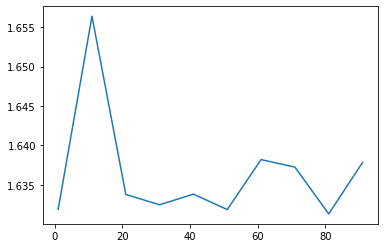

In [64]:
plt.plot(numbers, loss)
plt.show()

In [76]:

tm = []
numbers = []
for i in range (1, 101, 10):
  model_SVD = Net_SVD(model, i, [2, 3, 4])
  res = %timeit -o test_SVD(model_SVD, test_loader)
  numbers.append(i)

6.32 s ± 671 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.3 s ± 520 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.93 s ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.01 s ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.05 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.43 s ± 504 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.22 s ± 63.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.65 s ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.53 s ± 483 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.51 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Построим график, характеризующий потраченное время в зависимости от кол-ва сингулрных чисел, видно, что при их увеличении время работы увеличивается. Это происходит из-за того что приходится совершать более сложные вычисления с матрицами, т.к. чем больше кол-во сингулярных чисел, тем больше матрицы в сингулярном разложении

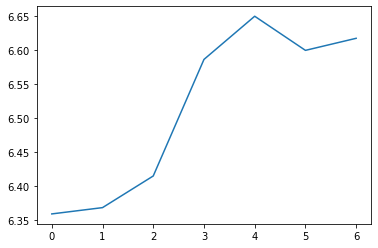

In [78]:
plt.plot(res.timings)
plt.show()

#Fine-tuning


Неясная ошибка, но обучение должно происходить таким образом, как я написал ниже

In [92]:
model_SVD = Net_SVD(model, 45, [2, 3, 4])
optimizer = optim.Adam(model_SVD.parameters(), lr=1e-4)
epochs = 1
for epoch in range(1, epochs + 1):
    train(model_SVD,  train_loader, optimizer, epoch)
    test(model_SVD, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Epoch: 1 [0/50000 (0%)]	Loss: 1.417265
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.355792
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.301290
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.273435
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.269251
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.416500
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.191609
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.281622
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.351383
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.168187

Test set: Average loss: 1.3577, Accuracy: 5270/10000 (53%)



Видим, что качество улучшилось, новая модель обучилась